# Variants of DnCNNs for Image Denoising
This example demonstrates the solution of an image denoising problem
using different DnCNN variants.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

from scico import functional, denoiser, metric, plot
import scico.random
import scico.numpy as snp
from scico._flax import load_weights, DnCNNNet
from scico.data import _flax_data_path

def denoise_(x_gt, σ, variant):
    """ Generate noisy image and denoise it via a DnCNN

    Args:
        x_gt: Reference image.
        σ: Noise level used for degrading the reference image.
        variant: Identify the DnCNN model to be used

    Returns:
        Denoised ouput, generated noisy image
    """

    non_blind_denoiser = ["6L", "6M", "6H", "17L", "17M", "17H"]
    blind_denoiser_with_noise_level_input = ["6V", "17V"]

    if variant not in non_blind_denoiser + blind_denoiser_with_noise_level_input:
            raise ValueError(f"Invalid value of parameter variant: {variant}")
    if variant[0] == "6":
        nlayer = 6
    else:
        nlayer = 17

    """
    Generate an noisy image
    """
    noise, key = scico.random.randn(x_gt.shape, seed=0)
    y = x_gt + σ * noise
    
    """
    Instanize a DnCNN and load the weights defined by variant
    """
    y_input = snp.stack([y, snp.ones_like(y) * σ], -1) if variant in blind_denoiser_with_noise_level_input else snp.expand_dims(y, -1)

    channels = 2 if variant in blind_denoiser_with_noise_level_input else 1

    model = DnCNNNet(depth=nlayer, channels=channels, num_filters=64, dtype=np.float32)
    variables = load_weights(_flax_data_path("dncnn%s.npz" % variant))

    x_hat = model.apply(variables, y_input, train=False, mutable=False)

    x_hat = np.clip(x_hat, a_min=0, a_max=1.0)

    x_hat = x_hat[..., 0]

    return x_hat, y

### Create a ground truth image.

In [2]:
np.random.seed(1234)
N = 512  # image size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU

### Test different DnCNN on images with different noise levels

In [4]:
print("  σ   | variant | noisy image PSNR (dB)   | denoised image PSNR (dB)")
for σ in [0.06, 0.1, 0.2]:
    for variant in ["6L", "6M", "6H", "6V", "17L", "17M", "17H", "17V"]:
        x_hat, y = denoise_(x_gt, σ, variant)

        if variant[0] == "6":
            variant += " "

        print(
            " %.2f | %s     |          %.2f          |          %.2f          " % (
                σ, variant, metric.psnr(x_gt, y), metric.psnr(x_gt, x_hat)))

    print("")

  σ   | variant | noisy image PSNR (dB)   | denoised image PSNR (dB)
 0.06 | 6L      |          24.43          |          33.80          
 0.06 | 6M      |          24.43          |          29.76          
 0.06 | 6H      |          24.43          |          26.86          
 0.06 | 6V      |          24.43          |          36.30          
 0.06 | 17L     |          24.43          |          33.82          
 0.06 | 17M     |          24.43          |          33.94          
 0.06 | 17H     |          24.43          |          26.32          
 0.06 | 17V     |          24.43          |          35.17          

 0.10 | 6L      |          19.99          |          27.87          
 0.10 | 6M      |          19.99          |          27.45          
 0.10 | 6H      |          19.99          |          26.52          
 0.10 | 6V      |          19.99          |          33.09          
 0.10 | 17L     |          19.99          |          27.43          
 0.10 | 17M     |          19.99 

### Show reference and denoised images.

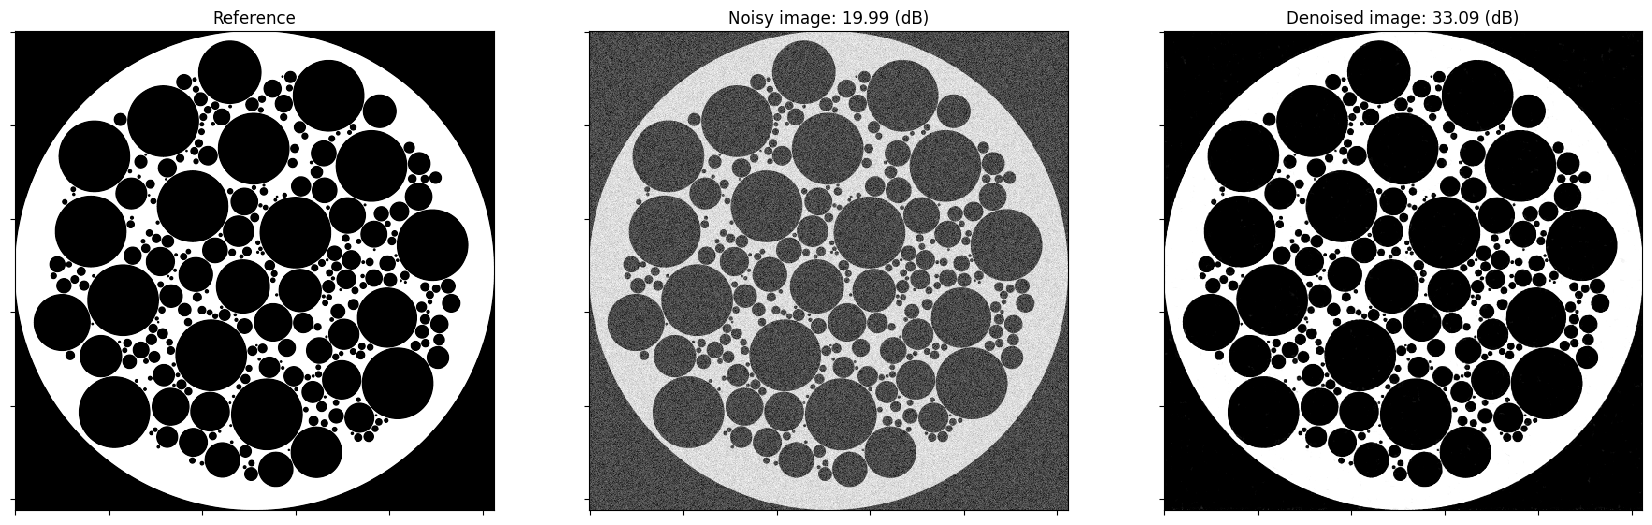

In [5]:
x_hat, y = denoise_(x_gt, 0.1, "6V")

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(21, 7))
plot.imview(x_gt, title="Reference", fig=fig, ax=ax[0])
plot.imview(y, title="Noisy image: %.2f (dB)" % metric.psnr(x_gt, y), fig=fig, ax=ax[1])
plot.imview(x_hat, title="Denoised image: %.2f (dB)" % metric.psnr(x_gt, x_hat), fig=fig, ax=ax[2])
fig.show()